In [1]:
import numpy as np
import pandas as pd

In [2]:
!ls ../data/lightning

bak		    CNLDN_20200901_raw.csv  ENGLN_20200901_raw.csv
CNLDN_20190725.csv  ENGLN_20190725_raw.csv  subset


# Read data

## CNLDN

In [3]:
df_cnldn_2019 = pd.read_csv('../data/lightning/CNLDN_20190725.csv')

In [4]:
df_cnldn_2020 = pd.read_csv('../data/lightning/CNLDN_20200901_raw.csv')

# rename for converting datetime
df_cnldn_2020.rename(columns = {'Lon':'longitude', 'Lat':'latitude', 'Mon':'month', 'Min': 'minute', 'MSecond': 'ms'}, inplace = True)

# set the correct format for ms
df_cnldn_2020['ms'] *= 1e-4
df_cnldn_2020['timestamp'] = pd.to_datetime(df_cnldn_2020.iloc[:, 2:-8], unit='ms')

# drop useless columns
keep_vars = ['longitude', 'latitude', 'timestamp']
df_cnldn_2020 = df_cnldn_2020[keep_vars]
df_cnldn_2020['type'] = 0

## ENGLN

In [5]:
keep_vars = ['type', 'longitude', 'latitude', 'timestamp']
df_engln_2019 = pd.read_csv('../data/lightning/ENGLN_20190725_raw.csv')
df_engln_2019 = df_engln_2019[keep_vars]

df_engln_2020 = pd.read_csv('../data/lightning/ENGLN_20200901_raw.csv')
df_engln_2020 = df_engln_2020[keep_vars]

## Save data

In [6]:
savedir = '../data/lightning/subset/'
df_cnldn_2019.to_csv(f'{savedir}CNLDN_20190725.csv', index=False)
df_cnldn_2020.to_csv(f'{savedir}CNLDN_20200901.csv', index=False)
df_engln_2019.to_csv(f'{savedir}ENGLN_20190725.csv', index=False)
df_engln_2020.to_csv(f'{savedir}ENGLN_20200901.csv', index=False)

## Read exported data again

In [7]:
names = ['type', 'timestamp', 'latitude', 'longitude']
types = ['int', 'str', 'float', 'float']
dtypes = dict(zip(names, types))

engln_2019 = pd.read_csv(f'{savedir}ENGLN_20190725.csv', delimiter=',', dtype=dtypes, parse_dates=['timestamp'], skipinitialspace=True)
engln_2020 = pd.read_csv(f'{savedir}ENGLN_20200901.csv', delimiter=',', dtype=dtypes, parse_dates=['timestamp'], skipinitialspace=True)
cnldn_2019 = pd.read_csv(f'{savedir}CNLDN_20190725.csv', delimiter=',', dtype=dtypes, parse_dates=['timestamp'], skipinitialspace=True)
cnldn_2020 = pd.read_csv(f'{savedir}CNLDN_20200901.csv', delimiter=',', dtype=dtypes, parse_dates=['timestamp'], skipinitialspace=True)

## Merging CNLDN and ENGLN

In [8]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c

    return km

In [9]:
def merge(cnldn, engln, dt, dx=10):
    '''
    Merge CNLDN and ENGLN data.
    Duplicated condition: dx (10 km) and dt (0.5 or 1 s)
    '''
    for i in range(engln.shape[0]):
        lat   = engln.iloc[i,:].latitude
        lat_1 = lat - 0.5
        lat_2 = lat + 0.5

        lon   = engln.iloc[i,:].longitude
        lon_1 = lon - 0.5
        lon_2 = lon + 0.5

        # narrow the range
        mask_1 = (lon_1 < cnldn.longitude) & (cnldn.longitude < lon_2) & \
                    (lat_1 < cnldn.latitude) & (cnldn.latitude < lat_2)

        # drop duplicated CG
        mask_2 = (cnldn['timestamp'] >= engln.iloc[i,:]['timestamp'] - pd.Timedelta(seconds=dt)) & \
                    (cnldn['timestamp'] < engln.iloc[i,:]['timestamp'] + pd.Timedelta(seconds=dt))

        if any(mask_1 & mask_2):
            for index, row in cnldn[mask_1&mask_2].infer_objects().iterrows():
                if haversine(row['longitude'], row['latitude'], lon, lat) <= dx:
                    cnldn = cnldn.drop(index)
#         break
    return cnldn

In [10]:
cnldn_2019_clean = merge(cnldn_2019, engln_2019, 1)
df_2019 = pd.concat([engln_2019, cnldn_2019_clean], ignore_index=True)

In [11]:
cnldn_2020_clean = merge(cnldn_2020, engln_2020, 0.5)
df_2020 = pd.concat([engln_2020, cnldn_2020_clean], ignore_index=True)

In [12]:
df_2019.to_csv(f"{savedir}LtgFlashPortions20190725.csv", header=True, index=False)#, mode="a")
df_2020.to_csv(f"{savedir}LtgFlashPortions20200901.csv", header=True, index=False)#, mode="a")

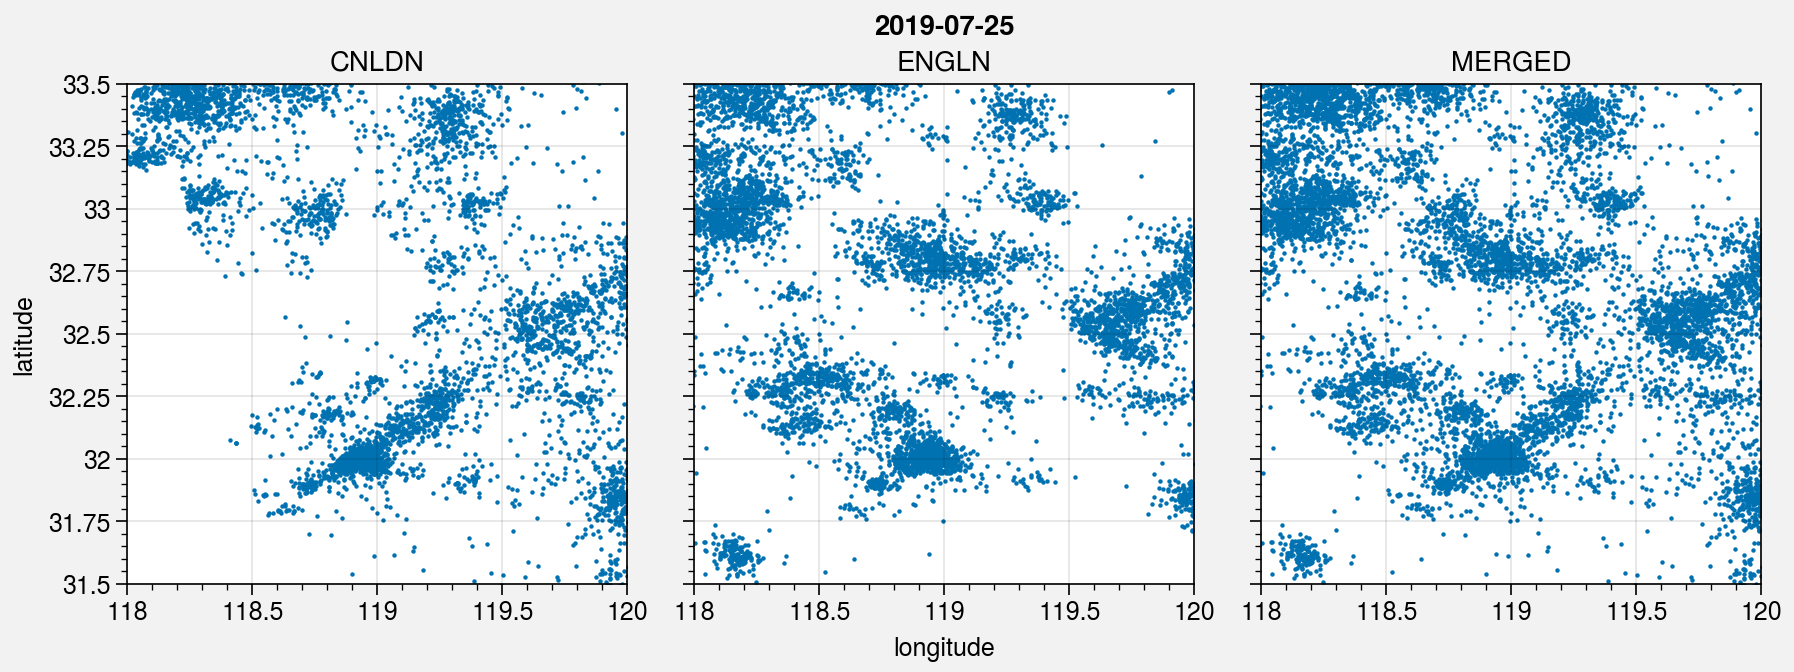

In [21]:
import proplot as plot

fig, axs = plot.subplots(ncols=3)

axs[0].scatter(cnldn_2019['longitude'], cnldn_2019['latitude'], size=1)
axs[0].format(title='CNLDN')
axs[1].scatter(engln_2019['longitude'], engln_2019['latitude'], size=1)
axs[1].format(title='ENGLN')
axs[2].scatter(df_2019['longitude'], df_2019['latitude'], size=1)
axs[2].format(title='MERGED')

axs.format(xlim=(118, 120), ylim=(31.5, 33.5), suptitle='2019-07-25')

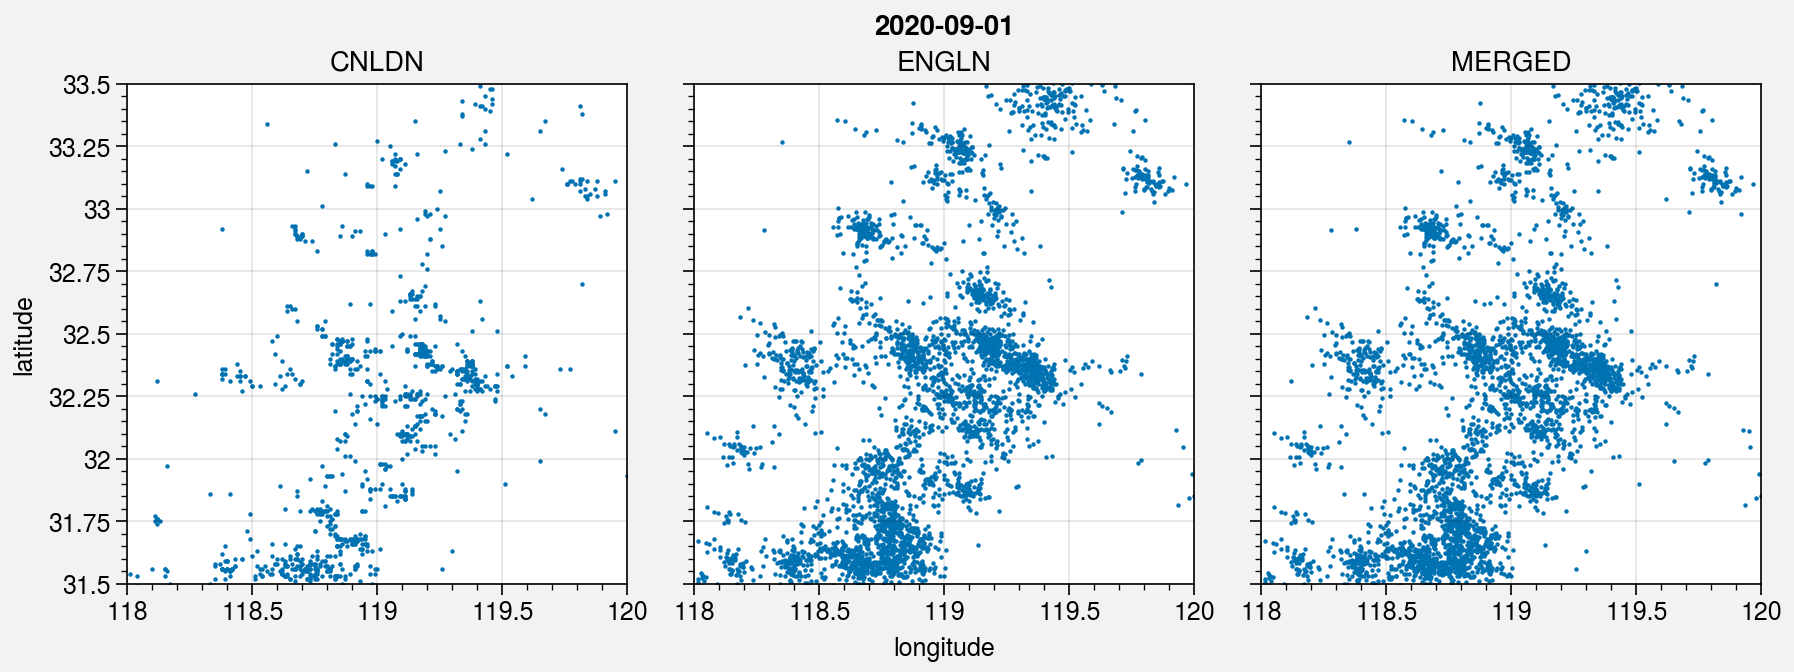

In [20]:
import proplot as plot

fig, axs = plot.subplots(ncols=3)

axs[0].scatter(cnldn_2020['longitude'], cnldn_2020['latitude'], size=1)
axs[0].format(title='CNLDN')
axs[1].scatter(engln_2020['longitude'], engln_2020['latitude'], size=1)
axs[1].format(title='ENGLN')
axs[2].scatter(df_2020['longitude'], df_2020['latitude'], size=1)
axs[2].format(title='MERGED')

axs.format(xlim=(118, 120), ylim=(31.5, 33.5), suptitle='2020-09-01')